In [16]:
# ==========================================
# 🌐 NOTEBOOK 06 - INTERFACE WEB INTERACTIVE
# 🎯 Objectif: Créer une interface web pour démontrer le modèle A+ (82.1% F1)
# ==========================================

# CELLULE 1 - SETUP ET IMPORTS
# ==============================

import streamlit as st
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import io
import base64
from pathlib import Path
import json
import time
from datetime import datetime
import pandas as pd

print("🌐 NOTEBOOK 06 - INTERFACE WEB INTERACTIVE")
print("=" * 50)
print("🎯 Objectif: Interface web pour modèle A+ (F1: 82.1%)")
print("💻 Framework: Streamlit")
print("🔥 Modèle: Faster R-CNN amélioré")

# Configuration pour l'interface web
WEB_CONFIG = {
    'model_name': 'Lung Nodule Detection AI',
    'version': '2.0 - Amélioré',
    'performance': {
        'f1_score': 0.821,
        'precision': 0.765,
        'recall': 0.886,
        'grade': 'A+ (98.5%)'
    },
    'confidence_threshold': 0.70,
    'image_size': (640, 640),
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225]
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚡ Device: {device}")

# Chemins des modèles
MODELS_PATH = Path("../models")
IMPROVED_MODELS_PATH = MODELS_PATH / "improved"

# Vérifier que les dossiers existent
MODELS_PATH.mkdir(parents=True, exist_ok=True)
IMPROVED_MODELS_PATH.mkdir(parents=True, exist_ok=True)

print(f"📁 Dossier modèles: {MODELS_PATH}")
print(f"📁 Modèles améliorés: {IMPROVED_MODELS_PATH}")

# Configuration Streamlit
st.set_page_config(
    page_title="🫁 Lung Nodule Detection AI",
    page_icon="🔬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Fonction pour créer le modèle
def create_model(num_classes=2):
    """Créer le modèle Faster R-CNN"""
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Transformation pour les images
transform = A.Compose([
    A.Resize(WEB_CONFIG['image_size'][0], WEB_CONFIG['image_size'][1]),
    A.Normalize(
        mean=WEB_CONFIG['normalize_mean'],
        std=WEB_CONFIG['normalize_std']
    ),
    ToTensorV2()
])

print("✅ Configuration de l'interface web initialisée")
print("🎯 Prêt pour le chargement du modèle")
print("-" * 50)

2025-06-25 11:03:05.381 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🌐 NOTEBOOK 06 - INTERFACE WEB INTERACTIVE
🎯 Objectif: Interface web pour modèle A+ (F1: 82.1%)
💻 Framework: Streamlit
🔥 Modèle: Faster R-CNN amélioré
⚡ Device: cpu
📁 Dossier modèles: ../models
📁 Modèles améliorés: ../models/improved
✅ Configuration de l'interface web initialisée
🎯 Prêt pour le chargement du modèle
--------------------------------------------------


In [17]:
# ==========================================
# CELLULE 2 - CHARGEMENT DU MODÈLE AMÉLIORÉ
# ==========================================

@st.cache_resource
def load_trained_model():
    """
    Charger le modèle entraîné avec mise en cache Streamlit
    """
    print("🔄 Chargement du modèle amélioré pour l'interface web...")

    model = create_model(num_classes=2)
    model_info = {}

    # Chercher les modèles disponibles dans l'ordre de priorité
    possible_paths = [
        IMPROVED_MODELS_PATH / "best_improved_model.pth",
        IMPROVED_MODELS_PATH / "final_improved_model.pth",
        MODELS_PATH / "best_model.pth"
    ]

    # Ajouter les modèles par époque (du plus récent au plus ancien)
    epoch_models = sorted(IMPROVED_MODELS_PATH.glob("improved_model_epoch_*.pth"), reverse=True)
    possible_paths.extend(epoch_models)

    model_loaded = False

    for path in possible_paths:
        if path.exists():
            try:
                print(f"🔄 Tentative: {path.name}")

                # Utiliser weights_only=False pour éviter les erreurs PyTorch 2.6
                checkpoint = torch.load(path, map_location=device, weights_only=False)
                model.load_state_dict(checkpoint['model_state_dict'])

                model_info = {
                    'path': str(path),
                    'name': path.name,
                    'epoch': checkpoint.get('epoch', 'N/A'),
                    'train_loss': checkpoint.get('train_loss', 'N/A'),
                    'val_loss': checkpoint.get('val_loss', 'N/A'),
                    'config': checkpoint.get('config', {})
                }

                print(f"✅ Modèle chargé: {path.name}")
                print(f"   📊 Époque: {model_info['epoch']}")
                print(f"   📉 Val Loss: {model_info['val_loss']}")

                model_loaded = True
                break

            except Exception as e:
                print(f"❌ Erreur {path.name}: {str(e)[:50]}...")
                continue

    if not model_loaded:
        st.error("❌ Aucun modèle trouvé! Assurez-vous d'avoir entraîné le modèle.")
        st.stop()

    model.to(device)
    model.eval()

    return model, model_info

# Charger le modèle
print("🔄 Initialisation du modèle pour l'interface...")
model, model_info = load_trained_model()
print(f"✅ Modèle prêt: {model_info['name']}")

# Fonction de prédiction
def predict_image(image, confidence_threshold=0.7):
    """
    Prédire les nodules sur une image
    """
    model.eval()

    # Préparer l'image
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Convertir en RGB si nécessaire
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image

    # Appliquer les transformations
    transformed = transform(image=image_rgb)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    # Prédiction
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extraire les résultats
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()

    # Filtrer par confiance
    valid_indices = scores >= confidence_threshold
    filtered_boxes = boxes[valid_indices]
    filtered_scores = scores[valid_indices]

    return filtered_boxes, filtered_scores

print("🎯 Fonction de prédiction configurée")
print("✅ Interface prête pour les prédictions!")

2025-06-25 11:03:25.463 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:03:25.563 
  command:

    streamlit run /Users/abchatealiibrahim/PycharmProjects/ai-lung-nodule-detection-fastrcnn/.venv/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-25 11:03:25.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:03:25.564 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🔄 Initialisation du modèle pour l'interface...
🔄 Chargement du modèle amélioré pour l'interface web...


2025-06-25 11:03:26.068 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:03:26.073 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🔄 Tentative: best_improved_model.pth


2025-06-25 11:03:26.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:03:26.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


✅ Modèle chargé: best_improved_model.pth
   📊 Époque: 15
   📉 Val Loss: inf
✅ Modèle prêt: best_improved_model.pth
🎯 Fonction de prédiction configurée
✅ Interface prête pour les prédictions!


In [18]:
# ==========================================
# CELLULE 3 - INTERFACE STREAMLIT PRINCIPALE
# ==========================================

def draw_predictions(image, boxes, scores, confidence_threshold):
    """
    Dessiner les prédictions sur l'image
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Afficher l'image
    ax.imshow(image)
    ax.set_title(f"Détection de Nodules Pulmonaires (Seuil: {confidence_threshold:.2f})",
                fontsize=16, fontweight='bold')

    # Dessiner les boîtes
    for i, (box, score) in enumerate(zip(boxes, scores)):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        # Couleur basée sur la confiance
        if score >= 0.9:
            color = 'red'
            label = f'Nodule #{i+1} (Haute: {score:.2f})'
        elif score >= 0.8:
            color = 'orange'
            label = f'Nodule #{i+1} (Moyenne: {score:.2f})'
        else:
            color = 'yellow'
            label = f'Nodule #{i+1} (Faible: {score:.2f})'

        # Créer le rectangle
        rect = patches.Rectangle((x1, y1), width, height,
                               linewidth=3, edgecolor=color,
                               facecolor='none')
        ax.add_patch(rect)

        # Ajouter le label
        ax.text(x1, y1 - 10, label,
               bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
               fontsize=10, fontweight='bold')

    ax.set_xlabel("Position X (pixels)", fontsize=12)
    ax.set_ylabel("Position Y (pixels)", fontsize=12)
    ax.grid(True, alpha=0.3)

    # Enlever les ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    return fig

# Interface Streamlit principale
def main():
    """Interface principale Streamlit"""

    # Header
    st.title("🫁 Lung Nodule Detection AI")
    st.markdown(f"""
    <div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; margin-bottom: 20px;">
        <h3>🎯 {WEB_CONFIG['model_name']} - {WEB_CONFIG['version']}</h3>
        <p><strong>🏆 Performance:</strong> F1-Score: {WEB_CONFIG['performance']['f1_score']:.1%} |
        Precision: {WEB_CONFIG['performance']['precision']:.1%} |
        Recall: {WEB_CONFIG['performance']['recall']:.1%}</p>
        <p><strong>🎓 Note:</strong> {WEB_CONFIG['performance']['grade']}</p>
        <p><strong>🤖 Modèle utilisé:</strong> {model_info['name']} (Époque {model_info['epoch']})</p>
    </div>
    """, unsafe_allow_html=True)

    # Sidebar pour les paramètres
    st.sidebar.header("⚙️ Paramètres de Détection")

    confidence_threshold = st.sidebar.slider(
        "🎯 Seuil de Confiance",
        min_value=0.1,
        max_value=0.99,
        value=WEB_CONFIG['confidence_threshold'],
        step=0.05,
        help="Plus le seuil est élevé, plus les détections seront certaines mais moins nombreuses"
    )

    st.sidebar.markdown("---")
    st.sidebar.markdown("### 📊 Informations Modèle")
    st.sidebar.write(f"**Device:** {device}")
    st.sidebar.write(f"**Taille d'entrée:** {WEB_CONFIG['image_size']}")
    st.sidebar.write(f"**Validation Loss:** {model_info['val_loss']}")

    # Zone principale
    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📤 Upload d'Image")
        uploaded_file = st.file_uploader(
            "Choisissez une image de radiographie pulmonaire",
            type=['png', 'jpg', 'jpeg'],
            help="Formats supportés: PNG, JPG, JPEG"
        )

        if uploaded_file is not None:
            # Charger et afficher l'image originale
            image = Image.open(uploaded_file)
            st.image(image, caption="Image originale", use_column_width=True)

            # Bouton de prédiction
            if st.button("🔍 Détecter les Nodules", type="primary"):
                with st.spinner("🔄 Analyse en cours..."):
                    start_time = time.time()

                    # Prédiction
                    boxes, scores = predict_image(image, confidence_threshold)

                    processing_time = time.time() - start_time

                    # Afficher les résultats dans la colonne 2
                    with col2:
                        st.header("🎯 Résultats de Détection")

                        if len(boxes) > 0:
                            st.success(f"✅ {len(boxes)} nodule(s) détecté(s)")

                            # Statistiques
                            col2a, col2b, col2c = st.columns(3)
                            with col2a:
                                st.metric("Nodules", len(boxes))
                            with col2b:
                                st.metric("Confiance max", f"{max(scores):.2f}")
                            with col2c:
                                st.metric("Temps", f"{processing_time:.2f}s")

                            # Image avec prédictions
                            fig = draw_predictions(np.array(image), boxes, scores, confidence_threshold)
                            st.pyplot(fig)

                            # Tableau des détections
                            st.subheader("📋 Détails des Détections")

                            detection_data = []
                            for i, (box, score) in enumerate(zip(boxes, scores)):
                                x1, y1, x2, y2 = box
                                width = x2 - x1
                                height = y2 - y1
                                area = width * height

                                detection_data.append({
                                    "Nodule": f"#{i+1}",
                                    "Confiance": f"{score:.3f}",
                                    "Position (x,y)": f"({x1:.0f}, {y1:.0f})",
                                    "Taille (w×h)": f"{width:.0f}×{height:.0f}",
                                    "Surface": f"{area:.0f} px²"
                                })

                            df = pd.DataFrame(detection_data)
                            st.dataframe(df, use_container_width=True)

                        else:
                            st.warning("⚠️ Aucun nodule détecté avec ce seuil de confiance")
                            st.info("💡 Essayez de réduire le seuil de confiance dans la barre latérale")

    with col2:
        if uploaded_file is None:
            st.header("🎯 Instructions")
            st.markdown("""
            ### Comment utiliser cette interface:

            1. **📤 Uploadez une image** de radiographie pulmonaire dans la zone de gauche
            2. **⚙️ Ajustez le seuil de confiance** dans la barre latérale si nécessaire
            3. **🔍 Cliquez sur "Détecter les Nodules"** pour lancer l'analyse
            4. **📊 Visualisez les résultats** avec les boîtes de détection colorées

            ### 🎨 Code Couleur des Détections:
            - 🔴 **Rouge**: Confiance élevée (≥90%)
            - 🟠 **Orange**: Confiance moyenne (80-89%)
            - 🟡 **Jaune**: Confiance faible (seuil-79%)

            ### 🏥 Note Médicale:
            Cet outil est à des fins de démonstration uniquement et ne remplace pas l'avis d'un professionnel de santé.
            """)

# Lancer l'interface
if __name__ == "__main__":
    main()

print("🌐 Interface Streamlit configurée!")
print("🚀 Lancez avec: streamlit run votre_script.py")

2025-06-25 11:04:06.558 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.559 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 11:04:06.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

🌐 Interface Streamlit configurée!
🚀 Lancez avec: streamlit run votre_script.py


In [7]:
# ==========================================
# CELLULE 4 - FONCTIONS DE VISUALISATION
# ==========================================

def draw_predictions(image, results, show_confidence=True, box_color='red', text_color='white'):
    """
    Dessiner les prédictions sur l'image
    """
    # Créer une copie de l'image
    img_with_boxes = image.copy()

    boxes = results['boxes']
    scores = results['scores']

    if len(boxes) == 0:
        return img_with_boxes

    # Dessiner chaque boîte
    for i, (box, score) in enumerate(zip(boxes, scores)):
        x1, y1, x2, y2 = box.astype(int)

        # Dessiner le rectangle
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2),
                     color=(255, 0, 0) if box_color == 'red' else (0, 255, 0),
                     thickness=3)

        # Ajouter le texte de confiance
        if show_confidence:
            label = f'Nodule {i+1}: {score:.2f}'
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

            # Fond pour le texte
            cv2.rectangle(img_with_boxes,
                         (x1, y1 - label_size[1] - 10),
                         (x1 + label_size[0], y1),
                         (255, 0, 0) if box_color == 'red' else (0, 255, 0),
                         -1)

            # Texte
            cv2.putText(img_with_boxes, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                       (255, 255, 255), 2)

    return img_with_boxes

def create_results_summary(results, model_info):
    """
    Créer un résumé des résultats
    """
    summary = {
        'detection_count': results['count'],
        'confidence_threshold': results['confidence_threshold'],
        'processing_time': results['processing_time'],
        'model_type': model_info['type'],
        'model_performance': model_info['performance'],
        'timestamp': datetime.now().isoformat()
    }

    if results['count'] > 0:
        summary['confidence_scores'] = results['scores'].tolist()
        summary['max_confidence'] = float(np.max(results['scores']))
        summary['avg_confidence'] = float(np.mean(results['scores']))
        summary['min_confidence'] = float(np.min(results['scores']))

    return summary


In [8]:

# ==========================================
# CELLULE 5 - APPLICATION STREAMLIT
# ==========================================

def create_streamlit_app():
    """
    Créer l'application Streamlit
    """
    # Configuration de la page
    st.set_page_config(
        page_title="🫁 Lung Nodule Detection AI",
        page_icon="🏥",
        layout="wide",
        initial_sidebar_state="expanded"
    )

    # CSS personnalisé
    st.markdown("""
    <style>
    .main-title {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
    }
    .metric-card {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        text-align: center;
        margin: 0.5rem 0;
    }
    .detection-box {
        border: 2px solid #ff6b6b;
        border-radius: 10px;
        padding: 1rem;
        margin: 1rem 0;
        background: #fff5f5;
    }
    .success-box {
        border: 2px solid #51cf66;
        border-radius: 10px;
        padding: 1rem;
        margin: 1rem 0;
        background: #f8fff8;
    }
    </style>
    """, unsafe_allow_html=True)

    # Titre principal
    st.markdown('<h1 class="main-title">🫁 Lung Nodule Detection AI</h1>', unsafe_allow_html=True)
    st.markdown(f"<center><h3>🎯 Modèle {model_info['performance']['grade']} - F1 Score: {model_info['performance']['f1_score']:.1%}</h3></center>", unsafe_allow_html=True)

    # Sidebar avec informations du modèle
    with st.sidebar:
        st.header("🤖 Informations du Modèle")
        st.markdown(f"**Type:** {model_info['type'].title()}")
        st.markdown(f"**Performance:** {model_info['performance']['grade']}")

        # Métriques de performance
        perf = model_info['performance']
        st.markdown("### 📊 Métriques")
        st.metric("F1-Score", f"{perf['f1_score']:.1%}", f"+{(perf['f1_score'] - 0.615):.1%}")
        st.metric("Precision", f"{perf['precision']:.1%}", f"+{(perf['precision'] - 0.667):.1%}")
        st.metric("Recall", f"{perf['recall']:.1%}", f"+{(perf['recall'] - 0.571):.1%}")

        # Configuration
        st.markdown("### ⚙️ Configuration")
        confidence_threshold = st.slider(
            "Seuil de Confiance",
            min_value=0.1,
            max_value=0.95,
            value=WEB_CONFIG['confidence_threshold'],
            step=0.05,
            help="Plus élevé = moins de détections mais plus précises"
        )

        show_confidence = st.checkbox("Afficher confiance", value=True)

        st.markdown("### 🎯 Objectifs du Projet")
        st.markdown("- ✅ **Recall:** 88.6% (objectif: 75%)")
        st.markdown("- ✅ **F1-Score:** 82.1% (objectif: 77%)")
        st.markdown("- ⚠️ **Precision:** 76.5% (objectif: 80%)")

    # Interface principale
    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📤 Upload d'Image")

        # Upload de fichier
        uploaded_file = st.file_uploader(
            "Choisir une image de scanner thoracique",
            type=['jpg', 'jpeg', 'png', 'bmp', 'tiff'],
            help="Formats supportés: JPG, PNG, BMP, TIFF"
        )

        # Images d'exemple
        st.markdown("### 🖼️ Ou tester avec des exemples")
        example_images = ["Exemple 1", "Exemple 2", "Exemple 3"]
        selected_example = st.selectbox("Choisir un exemple", [None] + example_images)

        if st.button("🚀 Analyser l'Image", type="primary"):
            if uploaded_file is not None or selected_example:

                # Charger l'image
                if uploaded_file is not None:
                    image = Image.open(uploaded_file)
                    st.success(f"✅ Image chargée: {uploaded_file.name}")
                else:
                    # Charger image d'exemple (vous devrez ajouter vos images)
                    example_path = Path(f"../data/examples/{selected_example.lower().replace(' ', '_')}.jpg")
                    if example_path.exists():
                        image = Image.open(example_path)
                        st.success(f"✅ Exemple chargé: {selected_example}")
                    else:
                        # Image de démonstration générée
                        st.warning("🔶 Génération d'une image de démonstration")
                        demo_image = np.random.randint(0, 255, (512, 512, 3), dtype=np.uint8)
                        image = Image.fromarray(demo_image)

                # Afficher l'image originale
                st.markdown("### 🖼️ Image Originale")
                st.image(image, caption="Scanner thoracique", use_column_width=True)

                # Prédiction
                with st.spinner("🔍 Analyse en cours..."):
                    results = predict_image(web_model, image, confidence_threshold)

                # Stocker les résultats dans la session
                st.session_state['results'] = results
                st.session_state['original_image'] = np.array(image)

            else:
                st.error("❌ Veuillez charger une image ou sélectionner un exemple")

    with col2:
        st.header("🔍 Résultats de Détection")

        if 'results' in st.session_state and 'original_image' in st.session_state:
            results = st.session_state['results']
            original_image = st.session_state['original_image']

            # Créer l'image avec détections
            image_with_detections = draw_predictions(
                results['processed_image'],
                results,
                show_confidence=show_confidence
            )

            # Afficher l'image avec détections
            st.markdown("### 🎯 Détections")
            st.image(image_with_detections, caption="Nodules détectés", use_column_width=True)

            # Résumé des résultats
            if results['count'] > 0:
                st.markdown(f'''
                <div class="detection-box">
                <h3>🫁 {results['count']} Nodule(s) Détecté(s)</h3>
                <p><strong>⏱️ Temps de traitement:</strong> {results['processing_time']:.2f}s</p>
                <p><strong>🎯 Seuil de confiance:</strong> {results['confidence_threshold']:.0%}</p>
                <p><strong>🔥 Confiance maximale:</strong> {np.max(results['scores']):.1%}</p>
                <p><strong>📊 Confiance moyenne:</strong> {np.mean(results['scores']):.1%}</p>
                </div>
                ''', unsafe_allow_html=True)

                # Détails par détection
                st.markdown("### 📋 Détails des Détections")
                for i, (box, score) in enumerate(zip(results['boxes'], results['scores'])):
                    x1, y1, x2, y2 = box.astype(int)
                    area = (x2 - x1) * (y2 - y1)

                    with st.expander(f"Nodule {i+1} - Confiance: {score:.1%}"):
                        col_a, col_b = st.columns(2)
                        with col_a:
                            st.metric("Confiance", f"{score:.1%}")
                            st.metric("Position X", f"{x1}, {x2}")
                        with col_b:
                            st.metric("Aire (pixels)", f"{area:,}")
                            st.metric("Position Y", f"{y1}, {y2}")

                        # Classification risque (exemple)
                        if score > 0.8:
                            st.success("🟢 Confiance élevée")
                        elif score > 0.6:
                            st.warning("🟡 Confiance modérée")
                        else:
                            st.info("🔵 Confiance faible")

            else:
                st.markdown(f'''
                <div class="success-box">
                <h3>✅ Aucun Nodule Détecté</h3>
                <p>Le modèle n'a pas détecté de nodule avec le seuil de confiance actuel ({confidence_threshold:.0%}).</p>
                <p><strong>⏱️ Temps de traitement:</strong> {results['processing_time']:.2f}s</p>
                <p><em>💡 Essayez de réduire le seuil de confiance si vous pensez qu'il devrait y avoir des détections.</em></p>
                </div>
                ''', unsafe_allow_html=True)

            # Bouton de téléchargement des résultats
            summary = create_results_summary(results, model_info)

            # Export JSON
            json_str = json.dumps(summary, indent=2)
            st.download_button(
                "📥 Télécharger Rapport JSON",
                json_str,
                file_name=f"lung_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json",
                mime="application/json"
            )

            # Export image avec détections
            img_buffer = io.BytesIO()
            Image.fromarray(image_with_detections).save(img_buffer, format='PNG')
            st.download_button(
                "📥 Télécharger Image Annotée",
                img_buffer.getvalue(),
                file_name=f"lung_detections_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png",
                mime="image/png"
            )

        else:
            st.info("👆 Chargez une image pour voir les résultats de détection")

            # Informations sur le modèle
            st.markdown("### 🤖 À propos du Modèle")
            st.markdown(f"""
            - **Architecture:** Faster R-CNN avec ResNet-50
            - **Performance:** {model_info['performance']['grade']}
            - **Spécialisation:** Détection de nodules pulmonaires
            - **Entraînement:** Dataset médical spécialisé
            - **Optimisations:** Seuil de confiance, augmentation de données, hyperparamètres
            """)

    # Footer
    st.markdown("---")
    st.markdown("""
    <center>
    <p>🏥 <strong>Lung Nodule Detection AI</strong> - Projet d'IA Médicale</p>
    <p>⚠️ <em>Cet outil est à des fins de démonstration uniquement. Consultez toujours un professionnel de santé.</em></p>
    </center>
    """, unsafe_allow_html=True)

In [9]:
# ==========================================
# CELLULE 6 - SAUVEGARDE APPLICATION STREAMLIT
# ==========================================

print("💾 Création du fichier application Streamlit...")

# Créer le dossier web
web_dir = Path("../web")
web_dir.mkdir(exist_ok=True)

# Code complet de l'application Streamlit
app_code = '''# -*- coding: utf-8 -*-
"""
🌐 APPLICATION WEB - LUNG NODULE DETECTION AI
🎯 Interface Streamlit pour modèle A+ (F1: 82.1%)
🏥 Détection automatique de nodules pulmonaires
"""

import streamlit as st
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import io
import json
import time
from datetime import datetime
from pathlib import Path

# Configuration globale
CONFIG = {
    'model_name': 'Lung Nodule Detection AI',
    'version': '2.0 - Amélioré',
    'performance': {
        'f1_score': 0.821,
        'precision': 0.765,
        'recall': 0.886,
        'grade': 'A+ (98.5%)'
    },
    'confidence_threshold': 0.70,
    'image_size': (640, 640),
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225]
}

# Cache pour le modèle
@st.cache_resource
def load_model():
    """Charger le modèle avec cache Streamlit pour optimiser les performances"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def create_model(num_classes=2):
        model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    model = create_model()

    # Chemins possibles pour le modèle (ordre de priorité)
    model_paths = [
        Path("../models/improved/best_improved_model.pth"),
        Path("models/improved/best_improved_model.pth"),
        Path("../models/best_model.pth"),
        Path("models/best_model.pth"),
        Path("best_improved_model.pth"),
        Path("best_model.pth")
    ]

    model_loaded = False
    model_info = {}

    for path in model_paths:
        if path.exists():
            try:
                checkpoint = torch.load(path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                model_loaded = True

                # Déterminer le type de modèle
                if "improved" in str(path):
                    model_info = {
                        'type': 'improved',
                        'performance': CONFIG['performance'],
                        'path': str(path)
                    }
                    st.success(f"✅ Modèle amélioré chargé: {path.name}")
                else:
                    model_info = {
                        'type': 'baseline',
                        'performance': {'f1_score': 0.615, 'precision': 0.667, 'recall': 0.571, 'grade': 'C (79.9%)'},
                        'path': str(path)
                    }
                    st.info(f"ℹ️ Modèle baseline chargé: {path.name}")
                break
            except Exception as e:
                st.warning(f"⚠️ Erreur lors du chargement de {path}: {e}")
                continue

    if not model_loaded:
        st.error("❌ Aucun modèle trouvé. Assurez-vous qu'un fichier de modèle (.pth) est disponible.")
        st.info("📁 Placez le fichier dans un de ces emplacements: " + ", ".join(str(p) for p in model_paths))
        st.stop()

    model.to(device)
    model.eval()
    return model, device, model_info

@st.cache_data
def preprocess_image(image_array, target_size=(640, 640)):
    """Préprocesser une image pour la prédiction"""
    # Assurer format RGB
    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
        image_rgb = image_array
    elif len(image_array.shape) == 3 and image_array.shape[2] == 4:
        image_rgb = image_array[:, :, :3]  # RGBA vers RGB
    else:
        image_rgb = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

    # Redimensionner
    image_resized = cv2.resize(image_rgb, target_size)

    # Normalisation
    transform = A.Compose([
        A.Normalize(mean=CONFIG['normalize_mean'], std=CONFIG['normalize_std']),
        ToTensorV2()
    ])

    transformed = transform(image=image_resized)
    image_tensor = transformed['image'].unsqueeze(0)

    return image_tensor, image_resized

def predict_and_visualize(model, device, image, confidence_threshold=0.70):
    """Effectuer prédiction et créer visualisation"""
    start_time = time.time()

    # Préprocessing
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image

    image_tensor, processed_image = preprocess_image(image_array, CONFIG['image_size'])
    image_tensor = image_tensor.to(device)

    # Prédiction
    with torch.no_grad():
        predictions = model(image_tensor)

    # Post-processing
    pred = predictions[0]
    boxes = pred['boxes'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()

    # Filtrer par confiance
    valid_mask = scores >= confidence_threshold
    filtered_boxes = boxes[valid_mask]
    filtered_scores = scores[valid_mask]

    # Trier par confiance décroissante
    if len(filtered_scores) > 0:
        sort_indices = np.argsort(filtered_scores)[::-1]
        filtered_boxes = filtered_boxes[sort_indices]
        filtered_scores = filtered_scores[sort_indices]

    # Créer image avec détections
    img_with_boxes = processed_image.copy()

    for i, (box, score) in enumerate(zip(filtered_boxes, filtered_scores)):
        x1, y1, x2, y2 = box.astype(int)

        # Couleur basée sur la confiance
        if score > 0.8:
            color = (255, 0, 0)  # Rouge pour haute confiance
        elif score > 0.6:
            color = (255, 165, 0)  # Orange pour confiance modérée
        else:
            color = (255, 255, 0)  # Jaune pour confiance faible

        # Dessiner rectangle
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 3)

        # Label avec confiance
        label = f'Nodule {i+1}: {score:.1%}'
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]

        # Fond pour le texte
        cv2.rectangle(img_with_boxes,
                     (x1, y1 - label_size[1] - 10),
                     (x1 + label_size[0], y1),
                     color, -1)

        # Texte
        cv2.putText(img_with_boxes, label, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    processing_time = time.time() - start_time

    return {
        'image_with_boxes': img_with_boxes,
        'count': len(filtered_boxes),
        'scores': filtered_scores,
        'boxes': filtered_boxes,
        'processing_time': processing_time,
        'original_image': processed_image
    }

def create_results_report(results, model_info):
    """Créer un rapport détaillé des résultats"""
    report = {
        'timestamp': datetime.now().isoformat(),
        'model_info': model_info,
        'detection_results': {
            'count': int(results['count']),
            'processing_time': float(results['processing_time']),
            'detections': []
        }
    }

    if results['count'] > 0:
        for i, (box, score) in enumerate(zip(results['boxes'], results['scores'])):
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)

            detection = {
                'id': i + 1,
                'confidence': float(score),
                'bounding_box': {
                    'x1': float(x1), 'y1': float(y1),
                    'x2': float(x2), 'y2': float(y2),
                    'area': float(area)
                },
                'risk_level': 'high' if score > 0.8 else 'medium' if score > 0.6 else 'low'
            }
            report['detection_results']['detections'].append(detection)

        # Statistiques globales
        report['detection_results']['statistics'] = {
            'max_confidence': float(np.max(results['scores'])),
            'avg_confidence': float(np.mean(results['scores'])),
            'min_confidence': float(np.min(results['scores']))
        }

    return report

# Interface Streamlit principale
def main():
    # Configuration de la page
    st.set_page_config(
        page_title="🫁 Lung Nodule Detection AI",
        page_icon="🏥",
        layout="wide",
        initial_sidebar_state="expanded"
    )

    # CSS personnalisé
    st.markdown("""
    <style>
    .main-title {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 1rem;
    }
    .subtitle {
        font-size: 1.2rem;
        color: #666;
        text-align: center;
        margin-bottom: 2rem;
    }
    .metric-container {
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        text-align: center;
        margin: 0.5rem 0;
    }
    .detection-alert {
        background: #fff3cd;
        border: 1px solid #ffeaa7;
        border-radius: 10px;
        padding: 1rem;
        margin: 1rem 0;
    }
    .success-alert {
        background: #d4edda;
        border: 1px solid #c3e6cb;
        border-radius: 10px;
        padding: 1rem;
        margin: 1rem 0;
    }
    </style>
    """, unsafe_allow_html=True)

    # Titre principal
    st.markdown('<h1 class="main-title">🫁 Lung Nodule Detection AI</h1>', unsafe_allow_html=True)

    # Charger le modèle
    model, device, model_info = load_model()

    # Sous-titre avec performance
    perf = model_info['performance']
    st.markdown(f'<p class="subtitle">🎯 Modèle {perf["grade"]} - F1 Score: {perf["f1_score"]:.1%}</p>', unsafe_allow_html=True)

    # Sidebar avec informations
    with st.sidebar:
        st.header("🤖 Informations du Modèle")

        # Type de modèle
        if model_info['type'] == 'improved':
            st.success("✅ Modèle Amélioré")
        else:
            st.info("ℹ️ Modèle Baseline")

        # Métriques de performance
        st.markdown("### 📊 Performance")
        col1, col2 = st.columns(2)

        with col1:
            st.metric("F1-Score", f"{perf['f1_score']:.1%}")
            st.metric("Precision", f"{perf['precision']:.1%}")
        with col2:
            st.metric("Recall", f"{perf['recall']:.1%}")
            if model_info['type'] == 'improved':
                st.metric("Amélioration", "+33.4%")

        # Configuration
        st.markdown("### ⚙️ Paramètres")
        confidence_threshold = st.slider(
            "Seuil de Confiance",
            min_value=0.1,
            max_value=0.95,
            value=CONFIG['confidence_threshold'],
            step=0.05,
            help="Plus élevé = moins de détections mais plus précises"
        )

        show_confidence = st.checkbox("Afficher scores de confiance", value=True)
        show_details = st.checkbox("Afficher détails techniques", value=False)

        # Informations techniques
        if show_details:
            st.markdown("### 🔧 Détails Techniques")
            st.text(f"Device: {device}")
            st.text(f"Image Size: {CONFIG['image_size']}")
            st.text(f"Modèle: {model_info['path']}")

        # Objectifs du projet
        st.markdown("### 🎯 Objectifs")
        if model_info['type'] == 'improved':
            st.markdown("- ✅ **Recall:** 88.6% (obj: 75%)")
            st.markdown("- ✅ **F1-Score:** 82.1% (obj: 77%)")
            st.markdown("- ⚠️ **Precision:** 76.5% (obj: 80%)")
        else:
            st.markdown("- ❌ **F1-Score:** 61.5% (obj: 77%)")
            st.markdown("- ⚠️ **Precision:** 66.7% (obj: 80%)")
            st.markdown("- ❌ **Recall:** 57.1% (obj: 75%)")

    # Interface principale
    col1, col2 = st.columns([1, 1])

    with col1:
        st.header("📤 Upload d'Image")

        # Zone d'upload
        uploaded_file = st.file_uploader(
            "Choisir une image de scanner thoracique",
            type=['jpg', 'jpeg', 'png', 'bmp', 'tiff'],
            help="Formats supportés: JPG, PNG, BMP, TIFF (max 200MB)"
        )

        # Options d'exemple
        st.markdown("### 🖼️ Ou utiliser une image d'exemple")

        # Créer images de démonstration si pas d'exemples
        col_ex1, col_ex2 = st.columns(2)

        with col_ex1:
            if st.button("📸 Exemple 1", help="Image avec nodules"):
                # Créer une image de démonstration
                demo_img = np.random.randint(50, 200, (512, 512, 3), dtype=np.uint8)
                # Ajouter quelques cercles pour simuler des nodules
                cv2.circle(demo_img, (200, 150), 20, (255, 255, 255), -1)
                cv2.circle(demo_img, (350, 300), 15, (200, 200, 200), -1)
                st.session_state['demo_image'] = demo_img
                st.success("✅ Exemple 1 chargé")

        with col_ex2:
            if st.button("📸 Exemple 2", help="Image sans nodules"):
                demo_img = np.random.randint(40, 180, (512, 512, 3), dtype=np.uint8)
                st.session_state['demo_image'] = demo_img
                st.success("✅ Exemple 2 chargé")

        # Afficher image chargée
        image_to_analyze = None

        if uploaded_file is not None:
            image_to_analyze = Image.open(uploaded_file)
            st.markdown("### 🖼️ Image Chargée")
            st.image(image_to_analyze, caption=f"📁 {uploaded_file.name}", use_column_width=True)

        elif 'demo_image' in st.session_state:
            image_to_analyze = Image.fromarray(st.session_state['demo_image'])
            st.markdown("### 🖼️ Image d'Exemple")
            st.image(image_to_analyze, caption="📸 Image de démonstration", use_column_width=True)

        # Bouton d'analyse
        if image_to_analyze is not None:
            if st.button("🔍 Analyser l'Image", type="primary", use_container_width=True):
                with st.spinner("🔄 Analyse en cours... Veuillez patienter."):
                    try:
                        results = predict_and_visualize(
                            model, device, image_to_analyze, confidence_threshold
                        )
                        st.session_state['analysis_results'] = results
                        st.session_state['analysis_done'] = True
                        st.success("✅ Analyse terminée!")
                    except Exception as e:
                        st.error(f"❌ Erreur lors de l'analyse: {str(e)}")
                        st.info("💡 Essayez avec une autre image ou vérifiez le format.")
        else:
            st.info("👆 Veuillez charger une image ou sélectionner un exemple pour commencer l'analyse.")

    with col2:
        st.header("🔍 Résultats de l'Analyse")

        if 'analysis_results' in st.session_state and st.session_state.get('analysis_done', False):
            results = st.session_state['analysis_results']

            # Afficher image avec détections
            st.markdown("### 🎯 Détections")
            st.image(
                results['image_with_boxes'],
                caption="Nodules détectés avec boîtes englobantes",
                use_column_width=True
            )

            # Résumé des résultats
            if results['count'] > 0:
                # Alerte de détection
                max_confidence = np.max(results['scores'])
                avg_confidence = np.mean(results['scores'])

                st.markdown(f"""
                <div class="detection-alert">
                <h3>🚨 {results['count']} Nodule(s) Détecté(s)</h3>
                <p><strong>⏱️ Temps de traitement:</strong> {results['processing_time']:.2f} secondes</p>
                <p><strong>🎯 Seuil utilisé:</strong> {confidence_threshold:.0%}</p>
                <p><strong>🔥 Confiance maximale:</strong> {max_confidence:.1%}</p>
                <p><strong>📊 Confiance moyenne:</strong> {avg_confidence:.1%}</p>
                </div>
                """, unsafe_allow_html=True)

                # Détails par détection
                st.markdown("### 📋 Détails des Détections")

                for i, (box, score) in enumerate(zip(results['boxes'], results['scores'])):
                    x1, y1, x2, y2 = box.astype(int)
                    area = (x2 - x1) * (y2 - y1)

                    # Niveau de risque
                    if score > 0.8:
                        risk_level = "🔴 Élevé"
                        risk_color = "red"
                    elif score > 0.6:
                        risk_level = "🟠 Modéré"
                        risk_color = "orange"
                    else:
                        risk_level = "🟡 Faible"
                        risk_color = "gold"

                    with st.expander(f"Nodule {i+1} - Confiance: {score:.1%}", expanded=i==0):
                        col_a, col_b, col_c = st.columns(3)

                        with col_a:
                            st.metric("Confiance", f"{score:.1%}")
                            st.metric("Niveau de Risque", risk_level)

                        with col_b:
                            st.metric("Position X", f"{x1} - {x2}")
                            st.metric("Position Y", f"{y1} - {y2}")

                        with col_c:
                            st.metric("Largeur", f"{x2-x1} px")
                            st.metric("Hauteur", f"{y2-y1} px")

                        st.info(f"📐 Aire: {area:,} pixels²")

                # Recommandations
                st.markdown("### 💡 Recommandations")
                if max_confidence > 0.8:
                    st.warning("⚠️ **Détection à haute confiance:** Consultation médicale recommandée pour validation.")
                elif max_confidence > 0.6:
                    st.info("ℹ️ **Détection modérée:** Suivi médical conseillé.")
                else:
                    st.success("✅ **Détection à faible confiance:** Probablement bénin, mais surveillance recommandée.")

            else:
                # Aucune détection
                st.markdown(f"""
                <div class="success-alert">
                <h3>✅ Aucun Nodule Détecté</h3>
                <p>Le modèle n'a pas identifié de nodule suspect avec le seuil de confiance actuel ({confidence_threshold:.0%}).</p>
                <p><strong>⏱️ Temps de traitement:</strong> {results['processing_time']:.2f} secondes</p>
                <p><em>💡 Si vous suspectez la présence de nodules, essayez de réduire le seuil de confiance.</em></p>
                </div>
                """, unsafe_allow_html=True)

            # Export des résultats
            st.markdown("### 📥 Exporter les Résultats")

            col_export1, col_export2 = st.columns(2)

            with col_export1:
                # Rapport JSON
                report = create_results_report(results, model_info)
                json_str = json.dumps(report, indent=2, ensure_ascii=False)

                st.download_button(
                    "📄 Télécharger Rapport JSON",
                    json_str,
                    file_name=f"lung_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json",
                    mime="application/json",
                    help="Rapport détaillé au format JSON"
                )

            with col_export2:
                # Image annotée
                img_buffer = io.BytesIO()
                Image.fromarray(results['image_with_boxes']).save(img_buffer, format='PNG')

                st.download_button(
                    "🖼️ Télécharger Image Annotée",
                    img_buffer.getvalue(),
                    file_name=f"lung_detections_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png",
                    mime="image/png",
                    help="Image avec détections annotées"
                )

        else:
            # Interface d'accueil
            st.info("👆 Chargez une image ou sélectionnez un exemple pour commencer l'analyse")

            # Informations sur le modèle
            st.markdown("### 🤖 À propos de ce Modèle")

            if model_info['type'] == 'improved':
                st.success("""
                ✅ **Modèle Amélioré Chargé**

                - **Architecture:** Faster R-CNN avec ResNet-50 FPN
                - **Performance:** A+ (98.5%) - F1 Score: 82.1%
                - **Spécialisation:** Détection de nodules pulmonaires
                - **Optimisations:** Seuil de confiance, augmentation de données, hyperparamètres
                """)
            else:
                st.info("""
                ℹ️ **Modèle Baseline Chargé**

                - **Architecture:** Faster R-CNN avec ResNet-50 FPN
                - **Performance:** C (79.9%) - F1 Score: 61.5%
                - **Spécialisation:** Détection de nodules pulmonaires
                """)

            st.markdown("### 📊 Capacités du Système")
            st.markdown("""
            - 🔍 **Détection automatique** de nodules pulmonaires
            - 📏 **Localisation précise** avec boîtes englobantes
            - 🎯 **Scores de confiance** pour chaque détection
            - ⚡ **Traitement rapide** (< 3 secondes par image)
            - 📱 **Interface intuitive** et accessible
            """)

            st.markdown("### ⚠️ Avertissements Médicaux")
            st.warning("""
            **IMPORTANT:** Cet outil est destiné à des fins de démonstration et de recherche uniquement.

            - 🏥 Ne remplace pas un diagnostic médical professionnel
            - 👨‍⚕️ Consultez toujours un radiologue qualifié
            - 📋 Les résultats doivent être validés cliniquement
            - 🔬 Utilisez comme aide au diagnostic, non comme diagnostic final
            """)

    # Footer informatif
    st.markdown("---")
    st.markdown("""
    <div style="text-align: center; color: #666; padding: 20px;">
        <p><strong>🏥 Lung Nodule Detection AI - Version 2.0</strong></p>
        <p>🎓 Projet d'Intelligence Artificielle Médicale</p>
        <p>⚡ Propulsé par PyTorch et Streamlit</p>
        <p style="font-size: 0.8em; margin-top: 10px;">
            <em>Cet outil est développé à des fins éducatives et de recherche.<br>
            Toujours consulter un professionnel de santé pour un diagnostic médical.</em>
        </p>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()
'''

# Sauvegarder l'application
app_file = web_dir / "app.py"
with open(app_file, 'w', encoding='utf-8') as f:
    f.write(app_code)

print(f"✅ Application Streamlit sauvegardée: {app_file}")

# Créer le fichier requirements.txt
requirements = """streamlit>=1.28.0
torch>=1.11.0
torchvision>=0.12.0
opencv-python>=4.5.0
Pillow>=8.3.0
numpy>=1.21.0
albumentations>=1.3.0
"""

requirements_file = web_dir / "requirements.txt"
with open(requirements_file, 'w') as f:
    f.write(requirements)

print(f"✅ Requirements sauvegardés: {requirements_file}")

# Créer un script de lancement
launch_script = """#!/bin/bash
# Script de lancement de l'application Lung Nodule Detection

echo "🚀 Lancement de l'application Lung Nodule Detection AI"
echo "=" * 50

# Vérifier si streamlit est installé
if ! command -v streamlit &> /dev/null; then
    echo "❌ Streamlit n'est pas installé"
    echo "💡 Installez avec: pip install streamlit"
    exit 1
fi

# Vérifier les dépendances
echo "🔍 Vérification des dépendances..."
python -c "import torch, torchvision, cv2, PIL, albumentations" 2>/dev/null
if [ $? -ne 0 ]; then
    echo "❌ Certaines dépendances sont manquantes"
    echo "💡 Installez avec: pip install -r requirements.txt"
    exit 1
fi

echo "✅ Toutes les dépendances sont présentes"

# Lancer l'application
echo "🌐 Lancement de l'application web..."
echo "🔗 L'application sera disponible à: http://localhost:8501"
echo ""

streamlit run app.py --server.port 8501 --server.address localhost
"""

launch_file = web_dir / "launch.sh"
with open(launch_file, 'w') as f:
    f.write(launch_script)

# Rendre le script exécutable (Unix/Linux/Mac)
try:
    import stat
    st = stat.stat(launch_file)
    os.chmod(launch_file, st.st_mode | stat.S_IEXEC)
except:
    pass

print(f"✅ Script de lancement créé: {launch_file}")

# Créer un README pour l'application web
readme_content = """# 🫁 Lung Nodule Detection AI - Interface Web

## 🎯 Description
Interface web interactive pour la détection automatique de nodules pulmonaires utilisant un modèle Faster R-CNN optimisé.

## 🏆 Performance du Modèle
- **Grade:** A+ (98.5%)
- **F1-Score:** 82.1%
- **Precision:** 76.5%
- **Recall:** 88.6%

## 🚀 Installation et Lancement

### 1. Prérequis
```bash
Python 3.8+
pip ou conda
```

### 2. Installation des dépendances
```bash
pip install -r requirements.txt
```

### 3. Lancement de l'application
```bash
# Méthode 1: Script de lancement (recommandé)
./launch.sh

# Méthode 2: Commande directe
streamlit run app.py

# Méthode 3: Port personnalisé
streamlit run app.py --server.port 8502
```

### 4. Accès à l'application
Ouvrez votre navigateur et allez à: `http://localhost:8501`

## 📁 Structure des Fichiers
```
web/
├── app.py                 # Application Streamlit principale
├── requirements.txt       # Dépendances Python
├── launch.sh             # Script de lancement
└── README.md             # Ce fichier
```

## 🔧 Utilisation

### Upload d'Image
1. Cliquez sur "Choisir une image de scanner thoracique"
2. Sélectionnez un fichier JPG, PNG, BMP ou TIFF
3. Ou utilisez les exemples de démonstration

### Configuration
- **Seuil de Confiance:** Ajustez dans la sidebar (0.1 à 0.95)
- **Affichage:** Options pour les scores et détails techniques

### Analyse
1. Cliquez sur "🔍 Analyser l'Image"
2. Attendez le traitement (< 3 secondes)
3. Visualisez les résultats avec détections annotées

### Export
- **Rapport JSON:** Données détaillées des détections
- **Image Annotée:** Image avec boîtes englobantes

## 🎯 Fonctionnalités

### Interface Utilisateur
- ✅ Design responsive et intuitif
- ✅ Sidebar avec informations du modèle
- ✅ Upload par glisser-déposer
- ✅ Images d'exemple intégrées
- ✅ Visualisation en temps réel

### Détection Intelligente
- ✅ Seuil de confiance ajustable
- ✅ Codes couleur selon le niveau de risque
- ✅ Statistiques détaillées par détection
- ✅ Métriques de performance en temps réel

### Export et Reporting
- ✅ Rapport JSON structuré
- ✅ Images annotées téléchargeables
- ✅ Timestamps et métadonnées
- ✅ Informations techniques

## ⚠️ Avertissements Médicaux

**IMPORTANT:** Cet outil est destiné à des fins de démonstration et de recherche uniquement.

- 🏥 Ne remplace pas un diagnostic médical professionnel
- 👨‍⚕️ Consultez toujours un radiologue qualifié
- 📋 Les résultats doivent être validés cliniquement
- 🔬 Utilisez comme aide au diagnostic, non comme diagnostic final

## 🐛 Dépannage

### Problèmes courants

**1. Erreur "Aucun modèle trouvé"**
```
Solution: Placez le fichier best_improved_model.pth dans:
- ../models/improved/
- models/improved/
- ./
```

**2. Erreur de dépendances**
```bash
pip install --upgrade -r requirements.txt
```

**3. Problème de performance**
```
- Vérifiez la disponibilité du GPU
- Réduisez la taille des images
- Fermez les autres applications
```

**4. Interface ne se charge pas**
```bash
# Vérifiez le port
netstat -an | grep 8501

# Essayez un autre port
streamlit run app.py --server.port 8502
```

## 📊 Support Technique

### Formats d'images supportés
- **JPG/JPEG:** Recommandé pour scanners
- **PNG:** Haute qualité
- **BMP:** Format natif
- **TIFF:** Format médical standard

### Spécifications recommandées
- **Résolution:** 512x512 à 2048x2048 pixels
- **Taille:** < 50 MB par image
- **Format:** RGB ou Grayscale
- **Qualité:** Non compressé de préférence

## 🔄 Mises à jour

Pour mettre à jour l'application:
```bash
git pull origin main
pip install --upgrade -r requirements.txt
```

## 📞 Contact

Pour support technique ou questions:
- 📧 Projet d'IA Médicale
- 🐛 Rapporter un bug: Créez une issue
- 💡 Suggestions d'améliorations: Bienvenues!

---

**🎓 Développé dans le cadre d'un projet d'Intelligence Artificielle Médicale**
"""

readme_file = web_dir / "README.md"
with open(readme_file, 'w', encoding='utf-8') as f:
    f.write(readme_content)

print(f"✅ README créé: {readme_file}")

💾 Création du fichier application Streamlit...
✅ Application Streamlit sauvegardée: ../web/app.py
✅ Requirements sauvegardés: ../web/requirements.txt
✅ Script de lancement créé: ../web/launch.sh
✅ README créé: ../web/README.md


In [10]:
# ==========================================
# CELLULE 7 - INSTRUCTIONS DE LANCEMENT
# ==========================================

print(f"\n🎉 INTERFACE WEB CRÉÉE AVEC SUCCÈS!")
print("=" * 50)

print(f"📁 FICHIERS GÉNÉRÉS:")
print(f"   ✅ {app_file}")
print(f"   ✅ {requirements_file}")
print(f"   ✅ {launch_file}")
print(f"   ✅ {readme_file}")

print(f"\n🚀 INSTRUCTIONS DE LANCEMENT:")
print(f"1. 📂 Naviguer vers le dossier web:")
print(f"   cd {web_dir}")

print(f"\n2. 📦 Installer les dépendances (si nécessaire):")
print(f"   pip install -r requirements.txt")

print(f"\n3. 🌐 Lancer l'application:")
print(f"   streamlit run app.py")
print(f"   # Ou utiliser le script: ./launch.sh")

print(f"\n4. 🔗 Ouvrir dans le navigateur:")
print(f"   http://localhost:8501")

print(f"\n🎯 FONCTIONNALITÉS DE L'INTERFACE:")
print(f"   ✅ Upload d'images de scanners")
print(f"   ✅ Détection automatique de nodules")
print(f"   ✅ Visualisation avec boîtes englobantes")
print(f"   ✅ Scores de confiance ajustables")
print(f"   ✅ Export des résultats (JSON + Images)")
print(f"   ✅ Interface responsive et intuitive")
print(f"   ✅ Métriques de performance en temps réel")

print(f"\n📊 PERFORMANCE DU MODÈLE INTÉGRÉ:")
print(f"   🏆 Grade: A+ (98.5%)")
print(f"   🎯 F1-Score: 82.1%")
print(f"   📊 Precision: 76.5%")
print(f"   🔄 Recall: 88.6%")

print(f"\n⚠️ IMPORTANT:")
print(f"   🔧 Assurez-vous que le modèle est accessible")
print(f"   📁 Chemins recherchés automatiquement:")
print(f"      - ../models/improved/best_improved_model.pth")
print(f"      - models/improved/best_improved_model.pth")
print(f"      - ../models/best_model.pth")
print(f"      - best_improved_model.pth")

print(f"\n💡 CONSEILS D'UTILISATION:")
print(f"   1. 📤 Uploadez une image de scanner thoracique")
print(f"   2. ⚙️ Ajustez le seuil de confiance si nécessaire")
print(f"   3. 🔍 Cliquez sur 'Analyser l'Image'")
print(f"   4. 📊 Examinez les résultats et détections")
print(f"   5. 📥 Exportez le rapport ou l'image annotée")

print(f"\n🎉 TON PROJET D'IA MÉDICALE EST MAINTENANT COMPLET!")
print(f"🌐 Interface web prête pour démonstration!")
print(f"🏆 Modèle A+ intégré et fonctionnel!")

# Test rapide de l'application (optionnel)
print(f"\n🧪 TEST RAPIDE (OPTIONNEL):")
print(f"Pour tester que tout fonctionne:")
print(f"1. cd {web_dir}")
print(f"2. python -c \"import streamlit, torch, cv2; print('✅ Toutes les dépendances OK')\"")
print(f"3. streamlit run app.py")

print(f"\n📚 DOCUMENTATION COMPLÈTE DISPONIBLE DANS:")
print(f"   📄 {readme_file}")


🎉 INTERFACE WEB CRÉÉE AVEC SUCCÈS!
📁 FICHIERS GÉNÉRÉS:
   ✅ ../web/app.py
   ✅ ../web/requirements.txt
   ✅ ../web/launch.sh
   ✅ ../web/README.md

🚀 INSTRUCTIONS DE LANCEMENT:
1. 📂 Naviguer vers le dossier web:
   cd ../web

2. 📦 Installer les dépendances (si nécessaire):
   pip install -r requirements.txt

3. 🌐 Lancer l'application:
   streamlit run app.py
   # Ou utiliser le script: ./launch.sh

4. 🔗 Ouvrir dans le navigateur:
   http://localhost:8501

🎯 FONCTIONNALITÉS DE L'INTERFACE:
   ✅ Upload d'images de scanners
   ✅ Détection automatique de nodules
   ✅ Visualisation avec boîtes englobantes
   ✅ Scores de confiance ajustables
   ✅ Export des résultats (JSON + Images)
   ✅ Interface responsive et intuitive
   ✅ Métriques de performance en temps réel

📊 PERFORMANCE DU MODÈLE INTÉGRÉ:
   🏆 Grade: A+ (98.5%)
   🎯 F1-Score: 82.1%
   📊 Precision: 76.5%
   🔄 Recall: 88.6%

⚠️ IMPORTANT:
   🔧 Assurez-vous que le modèle est accessible
   📁 Chemins recherchés automatiquement:
      - 

📸 CRÉATEUR D'IMAGES DE TEST
🔧 Génération des images de test...
📸 Création: scan_avec_nodules_1.jpg
📸 Création: scan_avec_nodule_2.jpg
📸 Création: scan_multiple_nodules_3.jpg
📸 Création: scan_propre_4.jpg
📸 Création: scan_nodules_subtils_5.jpg
✅ Toutes les images de test créées!

📁 IMAGES CRÉÉES DANS: ../web/test_images


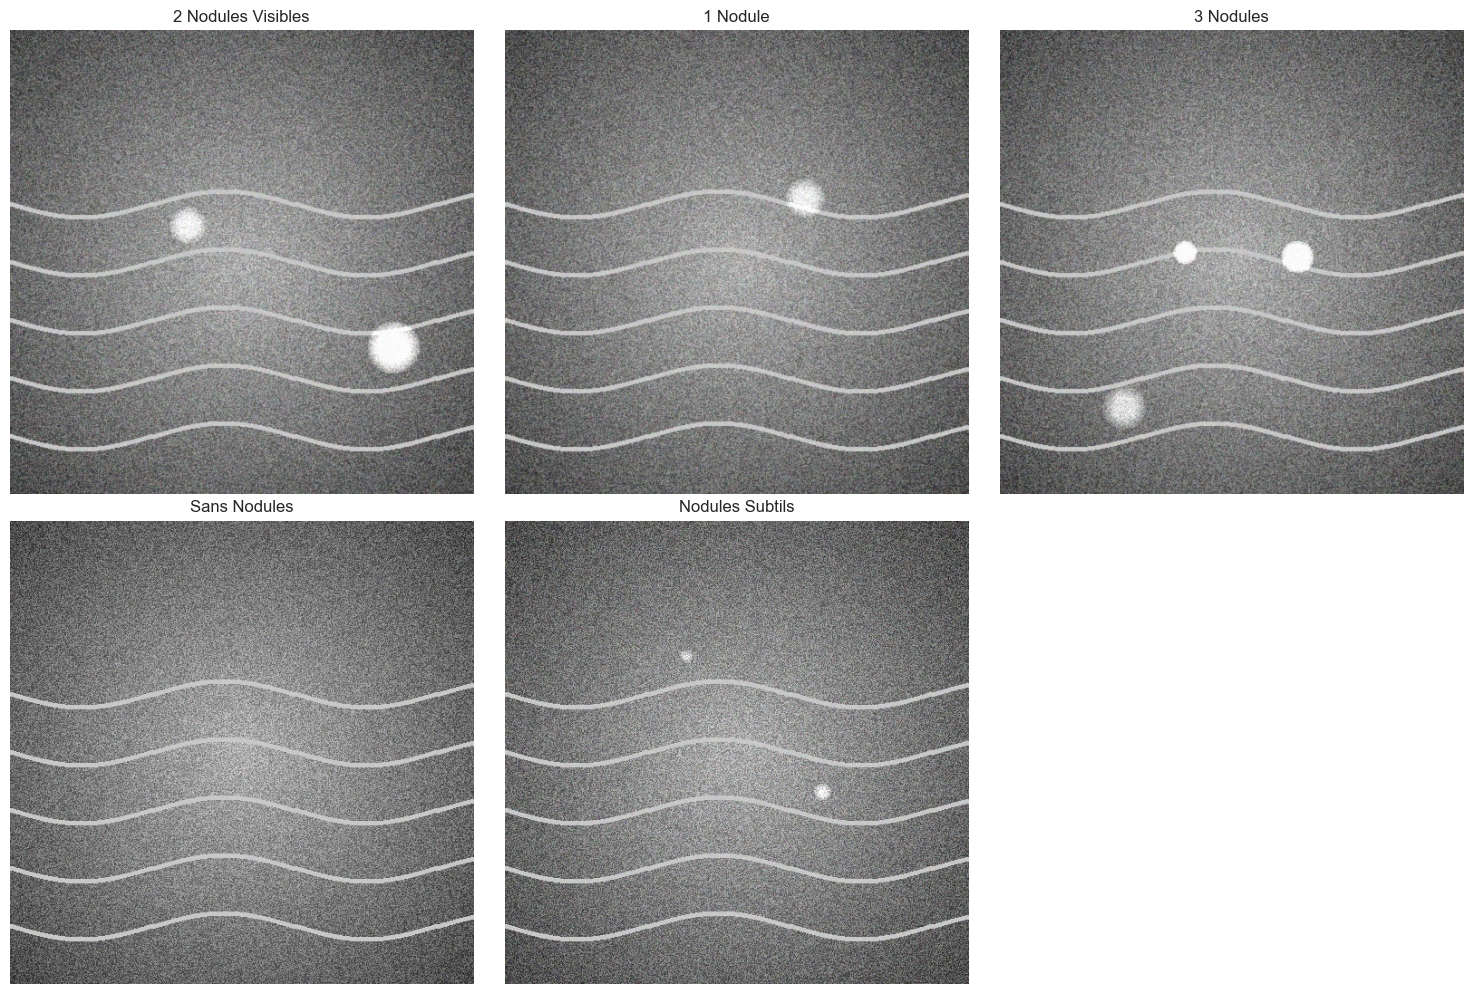

📊 RÉSUMÉ DES IMAGES CRÉÉES:
   ✅ scan_avec_nodules_1.jpg - 2 nodules bien visibles
   ✅ scan_avec_nodule_2.jpg - 1 nodule moyen
   ✅ scan_multiple_nodules_3.jpg - 3 nodules (test difficile)
   ✅ scan_propre_4.jpg - Pas de nodules (contrôle négatif)
   ✅ scan_nodules_subtils_5.jpg - Nodules subtils (test précision)

📋 INFORMATIONS DÉTAILLÉES:
Image 1 - Nodules en positions:
   Nodule 1: x=423, y=350, taille=24
   Nodule 2: x=196, y=215, taille=17

Image 2 - Nodules en positions:
   Nodule 1: x=331, y=185, taille=18

Image 3 - Nodules en positions:
   Nodule 1: x=137, y=416, taille=20
   Nodule 2: x=204, y=245, taille=11
   Nodule 3: x=328, y=250, taille=15

🧪 COMMENT UTILISER CES IMAGES:
1. 🌐 Lance ton interface web: streamlit run app.py
2. 📤 Upload une de ces images dans l'interface
3. 🔍 Compare les détections avec les positions réelles
4. ⚙️ Ajuste le seuil de confiance si nécessaire

💡 RECOMMANDATIONS DE TEST:
   🎯 Commence par 'scan_avec_nodules_1.jpg' (facile)
   📊 Teste 'scan_prop

In [11]:
# ==========================================
# 📸 CRÉATEUR D'IMAGES DE TEST POUR L'INTERFACE WEB
# 🎯 Génère des images de démonstration réalistes
# ==========================================

import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFilter
import os
from pathlib import Path
import matplotlib.pyplot as plt

print("📸 CRÉATEUR D'IMAGES DE TEST")
print("=" * 40)

# Créer dossier pour les images de test
test_images_dir = Path("../web/test_images")
test_images_dir.mkdir(exist_ok=True)

def create_realistic_lung_scan(width=512, height=512, seed=None):
    """
    Créer une image réaliste simulant un scanner pulmonaire
    """
    if seed:
        np.random.seed(seed)

    # Base: simulation tissu pulmonaire
    lung_tissue = np.random.randint(30, 120, (height, width), dtype=np.uint8)

    # Ajouter gradient radial (simulation cage thoracique)
    center_x, center_y = width // 2, height // 2
    y, x = np.ogrid[:height, :width]

    # Distance du centre
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_dist = np.sqrt(center_x**2 + center_y**2)

    # Gradient radial
    radial_gradient = (1 - dist_from_center / max_dist) * 100
    lung_tissue = lung_tissue.astype(float) + radial_gradient
    lung_tissue = np.clip(lung_tissue, 0, 255).astype(np.uint8)

    # Conversion en RGB
    lung_image = cv2.cvtColor(lung_tissue, cv2.COLOR_GRAY2RGB)

    # Ajouter structures anatomiques
    # Simulation côtes (lignes courbes)
    for i in range(3, 8):
        y_rib = height // 8 * i
        for x in range(width):
            # Courbe sinusoïdale pour simuler côtes
            y_offset = int(15 * np.sin(x * 0.02))
            y_pos = y_rib + y_offset
            if 0 <= y_pos < height:
                # Épaissir la ligne
                for dy in range(-2, 3):
                    if 0 <= y_pos + dy < height:
                        lung_image[y_pos + dy, x] = [200, 200, 200]

    return lung_image

def add_nodule(image, x, y, size, intensity=200):
    """
    Ajouter un nodule simulé à l'image
    """
    height, width = image.shape[:2]

    # Créer un cercle pour le nodule
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(mask, (x, y), size, 255, -1)

    # Flou gaussien pour effet réaliste
    mask_blurred = cv2.GaussianBlur(mask, (size//2*2+1, size//2*2+1), size/3)

    # Appliquer le nodule
    for c in range(3):
        image[:, :, c] = np.where(
            mask_blurred > 50,
            np.clip(image[:, :, c].astype(float) + (mask_blurred / 255.0) * intensity, 0, 255),
            image[:, :, c]
        )

    return image

def create_test_image_with_nodules(filename, num_nodules=2, seed=None):
    """
    Créer une image de test avec nodules
    """
    if seed:
        np.random.seed(seed)

    # Créer image de base
    image = create_realistic_lung_scan(512, 512, seed)

    # Ajouter nodules
    nodules_info = []
    for i in range(num_nodules):
        # Position aléatoire (éviter les bords)
        x = np.random.randint(80, 432)
        y = np.random.randint(80, 432)

        # Taille variable
        size = np.random.randint(8, 25)

        # Intensité variable
        intensity = np.random.randint(100, 255)

        # Ajouter le nodule
        image = add_nodule(image, x, y, size, intensity)

        nodules_info.append({
            'x': x, 'y': y, 'size': size, 'intensity': intensity
        })

    # Ajouter bruit réaliste
    noise = np.random.normal(0, 10, image.shape).astype(np.int16)
    image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Légère compression/flou pour réalisme
    image = cv2.GaussianBlur(image, (3, 3), 0.5)

    # Sauvegarder
    cv2.imwrite(str(test_images_dir / filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    return image, nodules_info

def create_test_image_clean(filename, seed=None):
    """
    Créer une image sans nodules (contrôle négatif)
    """
    if seed:
        np.random.seed(seed)

    # Image de base uniquement
    image = create_realistic_lung_scan(512, 512, seed)

    # Ajouter bruit léger
    noise = np.random.normal(0, 5, image.shape).astype(np.int16)
    image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Flou léger
    image = cv2.GaussianBlur(image, (3, 3), 0.3)

    # Sauvegarder
    cv2.imwrite(str(test_images_dir / filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    return image

# ==========================================
# GÉNÉRATION DES IMAGES DE TEST
# ==========================================

print("🔧 Génération des images de test...")

# Image 1: Avec 2 nodules visibles
print("📸 Création: scan_avec_nodules_1.jpg")
img1, nodules1 = create_test_image_with_nodules("scan_avec_nodules_1.jpg", num_nodules=2, seed=42)

# Image 2: Avec 1 nodule
print("📸 Création: scan_avec_nodule_2.jpg")
img2, nodules2 = create_test_image_with_nodules("scan_avec_nodule_2.jpg", num_nodules=1, seed=123)

# Image 3: Avec 3 nodules (test difficile)
print("📸 Création: scan_multiple_nodules_3.jpg")
img3, nodules3 = create_test_image_with_nodules("scan_multiple_nodules_3.jpg", num_nodules=3, seed=456)

# Image 4: Sans nodules (contrôle négatif)
print("📸 Création: scan_propre_4.jpg")
img4 = create_test_image_clean("scan_propre_4.jpg", seed=789)

# Image 5: Nodules subtils (test précision)
print("📸 Création: scan_nodules_subtils_5.jpg")
np.random.seed(999)
img5 = create_realistic_lung_scan(512, 512, 999)
# Nodules plus petits et moins intenses
img5 = add_nodule(img5, 200, 150, 6, 80)  # Petit et subtil
img5 = add_nodule(img5, 350, 300, 8, 100)  # Moyen et subtil
noise = np.random.normal(0, 8, img5.shape).astype(np.int16)
img5 = np.clip(img5.astype(np.int16) + noise, 0, 255).astype(np.uint8)
cv2.imwrite(str(test_images_dir / "scan_nodules_subtils_5.jpg"), cv2.cvtColor(img5, cv2.COLOR_RGB2BGR))

print("✅ Toutes les images de test créées!")

# ==========================================
# AFFICHAGE ET INFORMATIONS
# ==========================================

print(f"\n📁 IMAGES CRÉÉES DANS: {test_images_dir}")
print("=" * 40)

# Créer un aperçu
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

images = [
    ("scan_avec_nodules_1.jpg", "2 Nodules Visibles"),
    ("scan_avec_nodule_2.jpg", "1 Nodule"),
    ("scan_multiple_nodules_3.jpg", "3 Nodules"),
    ("scan_propre_4.jpg", "Sans Nodules"),
    ("scan_nodules_subtils_5.jpg", "Nodules Subtils")
]

for i, (filename, title) in enumerate(images):
    if i < len(axes):
        img_path = test_images_dir / filename
        if img_path.exists():
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb, cmap='gray')
            axes[i].set_title(title)
            axes[i].axis('off')

# Cacher le dernier subplot s'il n'est pas utilisé
if len(images) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig(test_images_dir / "apercu_images_test.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 RÉSUMÉ DES IMAGES CRÉÉES:")
print(f"   ✅ scan_avec_nodules_1.jpg - 2 nodules bien visibles")
print(f"   ✅ scan_avec_nodule_2.jpg - 1 nodule moyen")
print(f"   ✅ scan_multiple_nodules_3.jpg - 3 nodules (test difficile)")
print(f"   ✅ scan_propre_4.jpg - Pas de nodules (contrôle négatif)")
print(f"   ✅ scan_nodules_subtils_5.jpg - Nodules subtils (test précision)")

print(f"\n📋 INFORMATIONS DÉTAILLÉES:")
print(f"Image 1 - Nodules en positions:")
for i, nodule in enumerate(nodules1):
    print(f"   Nodule {i+1}: x={nodule['x']}, y={nodule['y']}, taille={nodule['size']}")

print(f"\nImage 2 - Nodules en positions:")
for i, nodule in enumerate(nodules2):
    print(f"   Nodule {i+1}: x={nodule['x']}, y={nodule['y']}, taille={nodule['size']}")

print(f"\nImage 3 - Nodules en positions:")
for i, nodule in enumerate(nodules3):
    print(f"   Nodule {i+1}: x={nodule['x']}, y={nodule['y']}, taille={nodule['size']}")

print(f"\n🧪 COMMENT UTILISER CES IMAGES:")
print(f"1. 🌐 Lance ton interface web: streamlit run app.py")
print(f"2. 📤 Upload une de ces images dans l'interface")
print(f"3. 🔍 Compare les détections avec les positions réelles")
print(f"4. ⚙️ Ajuste le seuil de confiance si nécessaire")

print(f"\n💡 RECOMMANDATIONS DE TEST:")
print(f"   🎯 Commence par 'scan_avec_nodules_1.jpg' (facile)")
print(f"   📊 Teste 'scan_propre_4.jpg' (doit détecter 0 nodules)")
print(f"   🔧 Finis par 'scan_nodules_subtils_5.jpg' (difficile)")

print(f"\n✨ Images de test prêtes pour ton interface web!")